# 天猫用户重复购买预测

## 一、数据探索

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_column",100)
pd.set_option("expand_frame_repr",False)
%matplotlib inline

## (一)读取数据

In [2]:
#1--读取数据
test_data=pd.read_csv(r'D:\文件\学习\数据集\天猫用户复购\data_format1\test_format1.csv')
train_data=pd.read_csv(r'D:\文件\学习\数据集\天猫用户复购\data_format1\train_format1.csv')
user_info=pd.read_csv(r'D:\文件\学习\数据集\天猫用户复购\data_format1\user_info_format1.csv')
user_log=pd.read_csv(r'D:\文件\学习\数据集\天猫用户复购\data_format1\user_log_format1.csv')

In [3]:
display(train_data.head())
display(test_data.head())
display(user_info.head())
display(user_log.head())

,user_id,merchant_id,label
0,34176,3906,0
1,34176,121,0
2,34176,4356,1
3,34176,2217,0
4,230784,4818,0


,user_id,merchant_id,prob
0,163968,4605,NaN
1,360576,1581,NaN
2,98688,1964,NaN
3,98688,3645,NaN
4,295296,3361,NaN


,user_id,age_range,gender
0,376517,6.0,1.0
1,234512,5.0,0.0
2,344532,5.0,0.0
3,186135,5.0,0.0
4,30230,5.0,0.0


,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
0,328862,323294,833,2882,2661.0,829,0
1,328862,844400,1271,2882,2661.0,829,0
2,328862,575153,1271,2882,2661.0,829,0
3,328862,996875,1271,2882,2661.0,829,0
4,328862,1086186,1271,1253,1049.0,829,0


In [4]:
display(train_data.info())
display(test_data.info())
display(user_info.info())
display(user_log.info())

&lt;class &#39;pandas.core.frame.DataFrame&#39;&gt;
RangeIndex: 260864 entries, 0 to 260863
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   user_id      260864 non-null  int64
 1   merchant_id  260864 non-null  int64
 2   label        260864 non-null  int64
dtypes: int64(3)
memory usage: 6.0 MB


None

&lt;class &#39;pandas.core.frame.DataFrame&#39;&gt;
RangeIndex: 261477 entries, 0 to 261476
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   user_id      261477 non-null  int64  
 1   merchant_id  261477 non-null  int64  
 2   prob         0 non-null       float64
dtypes: float64(1), int64(2)
memory usage: 6.0 MB


None

&lt;class &#39;pandas.core.frame.DataFrame&#39;&gt;
RangeIndex: 424170 entries, 0 to 424169
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    424170 non-null  int64  
 1   age_range  421953 non-null  float64
 2   gender     417734 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 9.7 MB


None

&lt;class &#39;pandas.core.frame.DataFrame&#39;&gt;
RangeIndex: 54925330 entries, 0 to 54925329
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   user_id      int64  
 1   item_id      int64  
 2   cat_id       int64  
 3   seller_id    int64  
 4   brand_id     float64
 5   time_stamp   int64  
 6   action_type  int64  
dtypes: float64(1), int64(6)
memory usage: 2.9 GB


None

## (二)查看缺失值

In [5]:
#查看user_info中age_range字段缺失比例
user_info["age_range"].isnull().sum()/user_info.shape[0]

0.005226677982884221

In [6]:
#age_range缺失数量
user_info["age_range"].isnull().sum()

2217

In [7]:
#查看age_range分布
user_info["age_range"].value_counts()

3.0    111654
0.0     92914
4.0     79991
2.0     52871
5.0     40777
6.0     35464
7.0      6992
8.0      1266
1.0        24
Name: age_range, dtype: int64

In [8]:
#查看user_info中gender字段确实比例
user_info["gender"].isnull().sum()/user_info.shape[0]

0.01517316170403376

In [9]:
#查看gender确实数量
user_info["gender"].isnull().sum()

6436

In [10]:
#查看gender分布
user_info["gender"].value_counts()

0.0    285638
1.0    121670
2.0     10426
Name: gender, dtype: int64

In [11]:
#查看user_log缺失情况
user_log.isnull().sum()

user_id            0
item_id            0
cat_id             0
seller_id          0
brand_id       91015
time_stamp         0
action_type        0
dtype: int64

In [12]:
user_info.describe()

,user_id,age_range,gender
count,424170.000000,421953.000000,417734.000000
mean,212085.500000,2.930262,0.341179
std,122447.476178,1.942978,0.524112
min,1.000000,0.000000,0.000000
25%,106043.250000,2.000000,0.000000
50%,212085.500000,3.000000,0.000000
75%,318127.750000,4.000000,1.000000
max,424170.000000,8.000000,2.000000


In [13]:
user_log.describe()

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
count,5.492533e+07,5.492533e+07,5.492533e+07,5.492533e+07,5.483432e+07,5.492533e+07,5.492533e+07
mean,2.121568e+05,5.538613e+05,8.770308e+02,2.470941e+03,4.153348e+03,9.230953e+02,2.854458e-01
std,1.222872e+05,3.221459e+05,4.486269e+02,1.473310e+03,2.397679e+03,1.954305e+02,8.075806e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.110000e+02,0.000000e+00
25%,1.063360e+05,2.731680e+05,5.550000e+02,1.151000e+03,2.027000e+03,7.300000e+02,0.000000e+00
50%,2.126540e+05,5.555290e+05,8.210000e+02,2.459000e+03,4.065000e+03,1.010000e+03,0.000000e+00
75%,3.177500e+05,8.306890e+05,1.252000e+03,3.760000e+03,6.196000e+03,1.109000e+03,0.000000e+00
max,4.241700e+05,1.113166e+06,1.671000e+03,4.995000e+03,8.477000e+03,1.112000e+03,3.000000e+00


In [14]:
label_gp=train_data["label"].value_counts()

In [15]:
label_gp

0    244912
1     15952
Name: label, dtype: int64

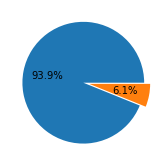

In [16]:
#查看样本不均衡情况并可视化
plt.figure(figsize=(6,6))
plt.subplot(1,2,1)
plt.pie(label_gp,autopct="%1.1f%%",explode=[0,0.1])
plt.show()

## (三)统计分析

In [17]:
train_data.head()

,user_id,merchant_id,label
0,34176,3906,0
1,34176,121,0
2,34176,4356,1
3,34176,2217,0
4,230784,4818,0


In [18]:
#查看购买次数前5的店铺的ID号
train_data_merchant=train_data["merchant_id"].value_counts().head(5) #value_counts会根据结果默认降序排列
train_data_merchant=pd.DataFrame(train_data_merchant)

In [19]:
train_data_merchant

,merchant_id
4044,3379
3828,3254
4173,2542
1102,2483
4976,1925


In [20]:
#查看购买次数前五的店铺的复购总次数

In [21]:
merchant_4044=train_data[train_data["merchant_id"]==4044]
merchant_3828=train_data[train_data["merchant_id"]==3828]
merchant_4173=train_data[train_data["merchant_id"]==4173]
merchant_1102=train_data[train_data["merchant_id"]==1102]
merchant_4976=train_data[train_data["merchant_id"]==4976]

In [22]:
merchant_id=pd.concat([merchant_4044,merchant_3828,merchant_4173,merchant_1102,merchant_4976],axis=0)
merchant_id

,user_id,merchant_id,label
101,315264,4044,0
279,153984,4044,0
305,28032,4044,1
565,76929,4044,0
612,280449,4044,0
...,...,...,...
259980,893,4976,0
260343,262526,4976,0
260349,1406,4976,0
260737,75647,4976,0


In [23]:
merchant_id_groupby=merchant_id.groupby("merchant_id").sum()
merchant_id_groupby

,user_id,label
merchant_id,,
1102,529518675,207
3828,687154793,410
4044,716175866,209
4173,539581960,173
4976,399349634,113


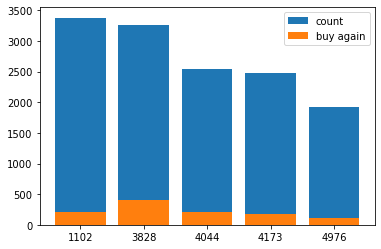

In [24]:
#查看销量前5的商户的复购数量
# plt.figure(figsize=(10,10))
plt.bar(x=range(1,6),height=train_data_merchant["merchant_id"],tick_label=train_data_merchant.index,label="count")
plt.bar(x=range(1,6),height=merchant_id_groupby["label"],tick_label=merchant_id_groupby.index,label="buy again")
plt.legend(loc="best")
plt.show()

In [25]:
train_data.memory_usage()

Index              128
user_id        2086912
merchant_id    2086912
label          2086912
dtype: int64

## （二）特征工程

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import gc 
from collections import Counter
import copy

import warnings
warnings.filterwarnings("ignore")
 
%matplotlib inline

### 1、数据内存压缩

In [27]:
# reduce memory
def reduce_mem_usage(df, verbose=True):
    #定义起始内存显示
    start_mem = df.memory_usage().sum() / 1024**2
    #定义一个数据类型的列表
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

    for col in df.columns:
        #定义col_type接受数据集各个字段的数据类型
        col_type = df[col].dtypes
        if col_type in numerics:
            #显示字段中单个数据占用的最小字节
            c_min = df[col].min()
            #显示字段中单个数据占用的最大字节
            c_max = df[col].max()
            #截取数据类型的前三位数
            if str(col_type)[:3] == 'int':
                #当前字段占用的最小字节数量和最大字节数量在int8类型的范围内，则将当前字段的数据类型转换成int8
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                #当前字段占用的最小字节数量和最大字节数量在float16类型的范围内，则将当前字段的数据类型转换成float16
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    #定义结束时的内存显示               
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [28]:
#调用内存压缩函数
train_data=reduce_mem_usage(train_data)
test_data=reduce_mem_usage(test_data)
user_info=reduce_mem_usage(user_info)
user_log=reduce_mem_usage(user_log)

Memory usage after optimization is: 1.74 MB
Decreased by 70.8%
Memory usage after optimization is: 3.49 MB
Decreased by 41.7%
Memory usage after optimization is: 3.24 MB
Decreased by 66.7%
Memory usage after optimization is: 890.48 MB
Decreased by 69.6%


In [29]:
# 进⾏内存回收并显示回收的数量
gc.collect()

5007

### 2、合并用户数据

In [30]:
#合并train_data,test_data,user_info三个表
all_data=train_data.append(test_data)
all_data=all_data.merge(user_info,on=["user_id"],how="left")


### 3、用户行为日志按时间排序

In [31]:
user_log=user_log.sort_values(["user_id","time_stamp"])
user_log.head()

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
23288890,1,181459,276,2245,4752.0,1009,0
23288891,1,779078,276,2245,4752.0,1009,0
23288892,1,779078,276,2245,4752.0,1009,0
23288893,1,452837,276,2245,4752.0,1009,0
23288894,1,543397,276,2245,4752.0,1009,0


### 4、合并user_log表中相同user_id的各个字段

In [32]:
list_join_func=lambda x:" ".join([str(i) for i in x])

In [33]:
#定义groupby的聚合方法
agg_dict={
    "item_id":list_join_func,
    "cat_id":list_join_func,
    "seller_id":list_join_func,
    "brand_id":list_join_func,
    "time_stamp":list_join_func,
    "action_type":list_join_func
}

In [34]:
#定义字段名称重命名
rename_dict={
    "item_id":"item_path",
    "cat_id":"cat_path",
    "seller_id":"seller_path",
    "brand_id":"brand_path",
    "time_stamp":"time_stamp_path",
    "action_type":"action_type_path"
}

In [35]:
user_log_path=user_log.groupby("user_id").agg(agg_dict).reset_index().rename(columns=rename_dict)

user_log_path.head()

,user_id,item_path,cat_path,seller_path,brand_path,time_stamp_path,action_type_path
0,1,181459 779078 779078 452837 543397 504149 5041...,276 276 276 276 276 1023 1023 1023 1023 1252 1...,2245 2245 2245 2245 2245 925 925 925 925 4026 ...,4752.0 4752.0 4752.0 4752.0 4752.0 7400.0 7400...,1009 1009 1009 1009 1009 1011 1011 1011 1011 1...,0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 0 0 0 0 0 2 2 ...
1,2,348983 749563 239288 751744 239288 714176 1972...,177 177 602 602 602 1213 602 602 602 1213 1213...,2223 2223 420 420 420 420 420 420 420 420 420 ...,3272.0 3272.0 4952.0 4952.0 4952.0 4058.0 4952...,527 527 626 626 626 626 626 626 626 626 626 62...,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 0 0 ...
2,3,895754 895754 182882 182882 985337 175397 9463...,1505 1505 1271 1271 1271 662 1134 1134 1134 45...,795 795 2123 2123 4925 1102 4461 4461 4461 474...,3608.0 3608.0 4796.0 4796.0 8004.0 1214.0 905....,516 516 627 627 627 727 819 819 820 906 906 90...,2 2 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
3,4,836727 243874 185489 95474 30073 790055 790055...,612 1577 1505 1505 1505 1505 1505 1505 1505 15...,1221 1221 1221 1221 1221 1221 1221 1221 1221 1...,7736.0 7736.0 7736.0 7736.0 7736.0 7736.0 7736...,527 527 527 527 527 527 527 527 527 527 527 52...,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
4,5,511956 728354 568450 754044 1011255 741215 362...,302 351 812 1213 142 464 1028 35 1213 351 142 ...,3098 3215 641 3736 1483 176 4848 641 3736 4547...,5544.0 5480.0 4264.0 3124.0 4640.0 6664.0 2804...,519 520 520 520 520 520 520 520 520 520 520 52...,3 0 0 2 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 ...


In [36]:
#合并all_data表和user_log_path表
all_data_path=all_data.merge(user_log_path,on="user_id")
all_data_path.head()

,user_id,merchant_id,label,prob,age_range,gender,item_path,cat_path,seller_path,brand_path,time_stamp_path,action_type_path
0,34176,3906,0.0,NaN,6.0,0.0,581818 879005 581818 581818 1011673 52343 2773...,1505 662 1505 1505 1505 662 1095 1505 662 1095...,416 3606 416 416 416 3760 3606 416 1926 3004 4...,4014.0 33.0 4014.0 4014.0 4014.0 3738.0 33.0 4...,521 521 521 521 521 521 521 521 521 521 521 52...,0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 ...
1,34176,121,0.0,NaN,6.0,0.0,581818 879005 581818 581818 1011673 52343 2773...,1505 662 1505 1505 1505 662 1095 1505 662 1095...,416 3606 416 416 416 3760 3606 416 1926 3004 4...,4014.0 33.0 4014.0 4014.0 4014.0 3738.0 33.0 4...,521 521 521 521 521 521 521 521 521 521 521 52...,0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 ...
2,34176,4356,1.0,NaN,6.0,0.0,581818 879005 581818 581818 1011673 52343 2773...,1505 662 1505 1505 1505 662 1095 1505 662 1095...,416 3606 416 416 416 3760 3606 416 1926 3004 4...,4014.0 33.0 4014.0 4014.0 4014.0 3738.0 33.0 4...,521 521 521 521 521 521 521 521 521 521 521 52...,0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 ...
3,34176,2217,0.0,NaN,6.0,0.0,581818 879005 581818 581818 1011673 52343 2773...,1505 662 1505 1505 1505 662 1095 1505 662 1095...,416 3606 416 416 416 3760 3606 416 1926 3004 4...,4014.0 33.0 4014.0 4014.0 4014.0 3738.0 33.0 4...,521 521 521 521 521 521 521 521 521 521 521 52...,0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 ...
4,230784,4818,0.0,NaN,0.0,0.0,191923 191923 191923 191923 964906 229470 2294...,1023 1023 1023 1023 662 664 664 1544 664 662 6...,3545 3545 3545 3545 4566 2537 2537 2420 2537 4...,5860.0 5860.0 5860.0 5860.0 6320.0 6064.0 6064...,601 601 601 601 614 614 614 614 614 614 618 61...,0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 ...


In [37]:
#删除内存中的user_log表并回收内存
# del user_log
# gc.collect()

### 5、定义数据统计函数

#### (1)定义统计函数

In [38]:
#统计数据的总数
def cnt_(x):
    try:
        return len(x.split(" "))
    except:
        return -1

In [39]:
#统计唯一数据总数
def nunique_(x):
    try:
        return len(set(x.split(" ")))
    except:
        return -1

In [40]:
#统计数据最大值
def max_(x):
    try:
        return np.max([int(i) for i in x.split(" ")])
    except:
        return -1

In [41]:
#统计数据最小值
def min_(x):
    try:
        return np.min([int(i) for i in x.split(" ")])
    except:
        return -1

In [42]:
#统计数据的标准差
def std_(x):
    try:
        return np.std([float(i) for i in x.split(" ")])
    except:
        return -1

In [43]:
#统计数据中top N的数据
def most_n(x,n):
    try:
        return Counter(x.split(" ")).most_common(n)[n-1][0]
    except:
        return -1

In [44]:
#统计数据中top N数据的总数
def most_n_cnt(x,n):
    try:
        return Counter(x.split(" ")).most_common(n)[n-1][1]
    except:
        return -1

#### (2)调用统计函数(调用的目的是生成新的一列)

In [45]:
#用户操作总次数
def user_cnt(df_data, single_col, name):
    df_data[name] = df_data[single_col].apply(cnt_)
    return df_data
#用户下单数量
def user_nunique(df_data, single_col, name):
    df_data[name] = df_data[single_col].apply(nunique_)
    return df_data
#用户下单最多
def user_max(df_data, single_col, name):
    df_data[name] = df_data[single_col].apply(max_)
    return df_data

def user_min(df_data, single_col, name):
    df_data[name] = df_data[single_col].apply(min_)
    return df_data
    
def user_std(df_data, single_col, name):
    df_data[name] = df_data[single_col].apply(std_)
    return df_data

def user_most_n(df_data, single_col, name, n=1):
    func = lambda x: most_n(x, n)
    df_data[name] = df_data[single_col].apply(func)
    return df_data

def user_most_n_cnt(df_data, single_col, name, n=1):
    func = lambda x: most_n_cnt(x, n)
    df_data[name] = df_data[single_col].apply(func)
    return df_data

### 6、提取商铺的基本统计特征(特征创造)

In [46]:
#前2000行作为测试样本(学习时使用，避免全量数据耗时过多)
all_data_test=all_data_path.head(2000)

In [47]:
#用户操作总次数(字段选择seller_path，因为每操作一次就有一个商户信息)
all_data_test=user_cnt(all_data_test,"seller_path","user_cnt")
all_data_test.head()

,user_id,merchant_id,label,prob,age_range,gender,item_path,cat_path,seller_path,brand_path,time_stamp_path,action_type_path,user_cnt
0,34176,3906,0.0,NaN,6.0,0.0,581818 879005 581818 581818 1011673 52343 2773...,1505 662 1505 1505 1505 662 1095 1505 662 1095...,416 3606 416 416 416 3760 3606 416 1926 3004 4...,4014.0 33.0 4014.0 4014.0 4014.0 3738.0 33.0 4...,521 521 521 521 521 521 521 521 521 521 521 52...,0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 ...,451
1,34176,121,0.0,NaN,6.0,0.0,581818 879005 581818 581818 1011673 52343 2773...,1505 662 1505 1505 1505 662 1095 1505 662 1095...,416 3606 416 416 416 3760 3606 416 1926 3004 4...,4014.0 33.0 4014.0 4014.0 4014.0 3738.0 33.0 4...,521 521 521 521 521 521 521 521 521 521 521 52...,0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 ...,451
2,34176,4356,1.0,NaN,6.0,0.0,581818 879005 581818 581818 1011673 52343 2773...,1505 662 1505 1505 1505 662 1095 1505 662 1095...,416 3606 416 416 416 3760 3606 416 1926 3004 4...,4014.0 33.0 4014.0 4014.0 4014.0 3738.0 33.0 4...,521 521 521 521 521 521 521 521 521 521 521 52...,0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 ...,451
3,34176,2217,0.0,NaN,6.0,0.0,581818 879005 581818 581818 1011673 52343 2773...,1505 662 1505 1505 1505 662 1095 1505 662 1095...,416 3606 416 416 416 3760 3606 416 1926 3004 4...,4014.0 33.0 4014.0 4014.0 4014.0 3738.0 33.0 4...,521 521 521 521 521 521 521 521 521 521 521 52...,0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 ...,451
4,230784,4818,0.0,NaN,0.0,0.0,191923 191923 191923 191923 964906 229470 2294...,1023 1023 1023 1023 662 664 664 1544 664 662 6...,3545 3545 3545 3545 4566 2537 2537 2420 2537 4...,5860.0 5860.0 5860.0 5860.0 6320.0 6064.0 6064...,601 601 601 601 614 614 614 614 614 614 618 61...,0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 ...,54


In [48]:
#不同店铺个数
all_data_test=user_nunique(all_data_test,"seller_path","seller_nunique")
all_data_test.head()

,user_id,merchant_id,label,prob,age_range,gender,item_path,cat_path,seller_path,brand_path,time_stamp_path,action_type_path,user_cnt,seller_nunique
0,34176,3906,0.0,NaN,6.0,0.0,581818 879005 581818 581818 1011673 52343 2773...,1505 662 1505 1505 1505 662 1095 1505 662 1095...,416 3606 416 416 416 3760 3606 416 1926 3004 4...,4014.0 33.0 4014.0 4014.0 4014.0 3738.0 33.0 4...,521 521 521 521 521 521 521 521 521 521 521 52...,0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 ...,451,109
1,34176,121,0.0,NaN,6.0,0.0,581818 879005 581818 581818 1011673 52343 2773...,1505 662 1505 1505 1505 662 1095 1505 662 1095...,416 3606 416 416 416 3760 3606 416 1926 3004 4...,4014.0 33.0 4014.0 4014.0 4014.0 3738.0 33.0 4...,521 521 521 521 521 521 521 521 521 521 521 52...,0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 ...,451,109
2,34176,4356,1.0,NaN,6.0,0.0,581818 879005 581818 581818 1011673 52343 2773...,1505 662 1505 1505 1505 662 1095 1505 662 1095...,416 3606 416 416 416 3760 3606 416 1926 3004 4...,4014.0 33.0 4014.0 4014.0 4014.0 3738.0 33.0 4...,521 521 521 521 521 521 521 521 521 521 521 52...,0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 ...,451,109
3,34176,2217,0.0,NaN,6.0,0.0,581818 879005 581818 581818 1011673 52343 2773...,1505 662 1505 1505 1505 662 1095 1505 662 1095...,416 3606 416 416 416 3760 3606 416 1926 3004 4...,4014.0 33.0 4014.0 4014.0 4014.0 3738.0 33.0 4...,521 521 521 521 521 521 521 521 521 521 521 52...,0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 ...,451,109
4,230784,4818,0.0,NaN,0.0,0.0,191923 191923 191923 191923 964906 229470 2294...,1023 1023 1023 1023 662 664 664 1544 664 662 6...,3545 3545 3545 3545 4566 2537 2537 2420 2537 4...,5860.0 5860.0 5860.0 5860.0 6320.0 6064.0 6064...,601 601 601 601 614 614 614 614 614 614 618 61...,0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 ...,54,20


In [49]:
# 不同品类个数
all_data_test = user_nunique(all_data_test,  'cat_path', 'cat_nunique')
# 不同品牌个数
all_data_test = user_nunique(all_data_test,  'brand_path', 'brand_nunique')
# 不同商品个数
all_data_test = user_nunique(all_data_test,  'item_path', 'item_nunique')
# 活跃天数
all_data_test = user_nunique(all_data_test,  'time_stamp_path', 'time_stamp_nunique')
# 同一用户产生的操作类型数量
all_data_test = user_nunique(all_data_test,  'action_type_path', 'action_type_nunique')
all_data_test.head()

,user_id,merchant_id,label,prob,age_range,gender,item_path,cat_path,seller_path,brand_path,time_stamp_path,action_type_path,user_cnt,seller_nunique,cat_nunique,brand_nunique,item_nunique,time_stamp_nunique,action_type_nunique
0,34176,3906,0.0,NaN,6.0,0.0,581818 879005 581818 581818 1011673 52343 2773...,1505 662 1505 1505 1505 662 1095 1505 662 1095...,416 3606 416 416 416 3760 3606 416 1926 3004 4...,4014.0 33.0 4014.0 4014.0 4014.0 3738.0 33.0 4...,521 521 521 521 521 521 521 521 521 521 521 52...,0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 ...,451,109,45,106,256,47,3
1,34176,121,0.0,NaN,6.0,0.0,581818 879005 581818 581818 1011673 52343 2773...,1505 662 1505 1505 1505 662 1095 1505 662 1095...,416 3606 416 416 416 3760 3606 416 1926 3004 4...,4014.0 33.0 4014.0 4014.0 4014.0 3738.0 33.0 4...,521 521 521 521 521 521 521 521 521 521 521 52...,0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 ...,451,109,45,106,256,47,3
2,34176,4356,1.0,NaN,6.0,0.0,581818 879005 581818 581818 1011673 52343 2773...,1505 662 1505 1505 1505 662 1095 1505 662 1095...,416 3606 416 416 416 3760 3606 416 1926 3004 4...,4014.0 33.0 4014.0 4014.0 4014.0 3738.0 33.0 4...,521 521 521 521 521 521 521 521 521 521 521 52...,0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 ...,451,109,45,106,256,47,3
3,34176,2217,0.0,NaN,6.0,0.0,581818 879005 581818 581818 1011673 52343 2773...,1505 662 1505 1505 1505 662 1095 1505 662 1095...,416 3606 416 416 416 3760 3606 416 1926 3004 4...,4014.0 33.0 4014.0 4014.0 4014.0 3738.0 33.0 4...,521 521 521 521 521 521 521 521 521 521 521 52...,0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 ...,451,109,45,106,256,47,3
4,230784,4818,0.0,NaN,0.0,0.0,191923 191923 191923 191923 964906 229470 2294...,1023 1023 1023 1023 662 664 664 1544 664 662 6...,3545 3545 3545 3545 4566 2537 2537 2420 2537 4...,5860.0 5860.0 5860.0 5860.0 6320.0 6064.0 6064...,601 601 601 601 614 614 614 614 614 614 618 61...,0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 ...,54,20,17,19,31,16,2


In [50]:
# 最晚时间
all_data_test = user_max(all_data_test,  'action_type_path', 'time_stamp_max')
# 最早时间
all_data_test = user_min(all_data_test,  'action_type_path', 'time_stamp_min')
# 活跃天数方差
all_data_test = user_std(all_data_test,  'action_type_path', 'time_stamp_std')
# 最早和最晚相差天数
all_data_test['time_stamp_range'] = all_data_test['time_stamp_max'] - all_data_test['time_stamp_min']
# 用户最喜欢的店铺
all_data_test = user_most_n(all_data_test, 'seller_path', 'seller_most_1', n=1)
# 最喜欢的类目
all_data_test = user_most_n(all_data_test, 'cat_path', 'cat_most_1', n=1)
# 最喜欢的品牌
all_data_test = user_most_n(all_data_test, 'brand_path', 'brand_most_1', n=1)
# 最常见的行为动作
all_data_test = user_most_n(all_data_test, 'action_type_path', 'action_type_1', n=1)
# 用户最喜欢的店铺 行为次数
all_data_test = user_most_n_cnt(all_data_test, 'seller_path', 'seller_most_1_cnt', n=1)
# 最喜欢的类目 行为次数
all_data_test = user_most_n_cnt(all_data_test, 'cat_path', 'cat_most_1_cnt', n=1)
# 最喜欢的品牌 行为次数
all_data_test = user_most_n_cnt(all_data_test, 'brand_path', 'brand_most_1_cnt', n=1)
# 最常见的行为动作 行为次数
all_data_test = user_most_n_cnt(all_data_test, 'action_type_path', 'action_type_1_cnt', n=1)
all_data_test.head()

,user_id,merchant_id,label,prob,age_range,gender,item_path,cat_path,seller_path,brand_path,time_stamp_path,action_type_path,user_cnt,seller_nunique,cat_nunique,brand_nunique,item_nunique,time_stamp_nunique,action_type_nunique,time_stamp_max,time_stamp_min,time_stamp_std,time_stamp_range,seller_most_1,cat_most_1,brand_most_1,action_type_1,seller_most_1_cnt,cat_most_1_cnt,brand_most_1_cnt,action_type_1_cnt
0,34176,3906,0.0,NaN,6.0,0.0,581818 879005 581818 581818 1011673 52343 2773...,1505 662 1505 1505 1505 662 1095 1505 662 1095...,416 3606 416 416 416 3760 3606 416 1926 3004 4...,4014.0 33.0 4014.0 4014.0 4014.0 3738.0 33.0 4...,521 521 521 521 521 521 521 521 521 521 521 52...,0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 ...,451,109,45,106,256,47,3,3,0,0.634270,3,331,662,4094.0,0,70,98,70,410
1,34176,121,0.0,NaN,6.0,0.0,581818 879005 581818 581818 1011673 52343 2773...,1505 662 1505 1505 1505 662 1095 1505 662 1095...,416 3606 416 416 416 3760 3606 416 1926 3004 4...,4014.0 33.0 4014.0 4014.0 4014.0 3738.0 33.0 4...,521 521 521 521 521 521 521 521 521 521 521 52...,0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 ...,451,109,45,106,256,47,3,3,0,0.634270,3,331,662,4094.0,0,70,98,70,410
2,34176,4356,1.0,NaN,6.0,0.0,581818 879005 581818 581818 1011673 52343 2773...,1505 662 1505 1505 1505 662 1095 1505 662 1095...,416 3606 416 416 416 3760 3606 416 1926 3004 4...,4014.0 33.0 4014.0 4014.0 4014.0 3738.0 33.0 4...,521 521 521 521 521 521 521 521 521 521 521 52...,0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 ...,451,109,45,106,256,47,3,3,0,0.634270,3,331,662,4094.0,0,70,98,70,410
3,34176,2217,0.0,NaN,6.0,0.0,581818 879005 581818 581818 1011673 52343 2773...,1505 662 1505 1505 1505 662 1095 1505 662 1095...,416 3606 416 416 416 3760 3606 416 1926 3004 4...,4014.0 33.0 4014.0 4014.0 4014.0 3738.0 33.0 4...,521 521 521 521 521 521 521 521 521 521 521 52...,0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 ...,451,109,45,106,256,47,3,3,0,0.634270,3,331,662,4094.0,0,70,98,70,410
4,230784,4818,0.0,NaN,0.0,0.0,191923 191923 191923 191923 964906 229470 2294...,1023 1023 1023 1023 662 664 664 1544 664 662 6...,3545 3545 3545 3545 4566 2537 2537 2420 2537 4...,5860.0 5860.0 5860.0 5860.0 6320.0 6064.0 6064...,601 601 601 601 614 614 614 614 614 614 618 61...,0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 ...,54,20,17,19,31,16,2,2,0,0.671791,2,3556,407,1236.0,0,10,9,10,47


### 7、分开统计用户的点击、加购、购买、收藏特征

In [51]:
#不同行为的业务函数定义
def col_cnt_(df_data, columns_list, action_type):
    try:
        data_dict = {}

        col_list = copy.deepcopy(columns_list)
        if action_type != None:
            col_list += ['action_type_path']

        for col in col_list:
            data_dict[col] = df_data[col].split(' ')

        path_len = len(data_dict[col])

        data_out = []
        for i_ in range(path_len):
            data_txt = ''
            for col_ in columns_list:
                if data_dict['action_type_path'][i_] == action_type:
                    data_txt += '_' + data_dict[col_][i_]
            data_out.append(data_txt)

        return len(data_out)  
    except:
        return -1

def col_nuique_(df_data, columns_list, action_type):
    try:
        data_dict = {}

        col_list = copy.deepcopy(columns_list)
        if action_type != None:
            col_list += ['action_type_path']

        for col in col_list:
            data_dict[col] = df_data[col].split(' ')

        path_len = len(data_dict[col])

        data_out = []
        for i_ in range(path_len):
            data_txt = ''
            for col_ in columns_list:
                if data_dict['action_type_path'][i_] == action_type:
                    data_txt += '_' + data_dict[col_][i_]
            data_out.append(data_txt)

        return len(set(data_out))
    except:
        return -1
    

def user_col_cnt(df_data, columns_list, action_type, name):
    df_data[name] = df_data.apply(lambda x: col_cnt_(x, columns_list, action_type), axis=1)
    return df_data

def user_col_nunique(df_data, columns_list, action_type, name):
    df_data[name] = df_data.apply(lambda x: col_nuique_(x, columns_list, action_type), axis=1)
    return df_data

In [52]:
# 点击次数
all_data_test = user_col_cnt(all_data_test,  ['seller_path'], '0', 'user_cnt_0')
# 加购次数
all_data_test = user_col_cnt(all_data_test,  ['seller_path'], '1', 'user_cnt_1')
# 购买次数
all_data_test = user_col_cnt(all_data_test,  ['seller_path'], '2', 'user_cnt_2')
# 收藏次数
all_data_test = user_col_cnt(all_data_test,  ['seller_path'], '3', 'user_cnt_3')
# 不同店铺个数
all_data_test = user_col_nunique(all_data_test,  ['seller_path'], '0', 'seller_nunique_0')

all_data_test.head()

,user_id,merchant_id,label,prob,age_range,gender,item_path,cat_path,seller_path,brand_path,time_stamp_path,action_type_path,user_cnt,seller_nunique,cat_nunique,brand_nunique,item_nunique,time_stamp_nunique,action_type_nunique,time_stamp_max,time_stamp_min,time_stamp_std,time_stamp_range,seller_most_1,cat_most_1,brand_most_1,action_type_1,seller_most_1_cnt,cat_most_1_cnt,brand_most_1_cnt,action_type_1_cnt,user_cnt_0,user_cnt_1,user_cnt_2,user_cnt_3,seller_nunique_0
0,34176,3906,0.0,NaN,6.0,0.0,581818 879005 581818 581818 1011673 52343 2773...,1505 662 1505 1505 1505 662 1095 1505 662 1095...,416 3606 416 416 416 3760 3606 416 1926 3004 4...,4014.0 33.0 4014.0 4014.0 4014.0 3738.0 33.0 4...,521 521 521 521 521 521 521 521 521 521 521 52...,0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 ...,451,109,45,106,256,47,3,3,0,0.634270,3,331,662,4094.0,0,70,98,70,410,451,451,451,451,107
1,34176,121,0.0,NaN,6.0,0.0,581818 879005 581818 581818 1011673 52343 2773...,1505 662 1505 1505 1505 662 1095 1505 662 1095...,416 3606 416 416 416 3760 3606 416 1926 3004 4...,4014.0 33.0 4014.0 4014.0 4014.0 3738.0 33.0 4...,521 521 521 521 521 521 521 521 521 521 521 52...,0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 ...,451,109,45,106,256,47,3,3,0,0.634270,3,331,662,4094.0,0,70,98,70,410,451,451,451,451,107
2,34176,4356,1.0,NaN,6.0,0.0,581818 879005 581818 581818 1011673 52343 2773...,1505 662 1505 1505 1505 662 1095 1505 662 1095...,416 3606 416 416 416 3760 3606 416 1926 3004 4...,4014.0 33.0 4014.0 4014.0 4014.0 3738.0 33.0 4...,521 521 521 521 521 521 521 521 521 521 521 52...,0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 ...,451,109,45,106,256,47,3,3,0,0.634270,3,331,662,4094.0,0,70,98,70,410,451,451,451,451,107
3,34176,2217,0.0,NaN,6.0,0.0,581818 879005 581818 581818 1011673 52343 2773...,1505 662 1505 1505 1505 662 1095 1505 662 1095...,416 3606 416 416 416 3760 3606 416 1926 3004 4...,4014.0 33.0 4014.0 4014.0 4014.0 3738.0 33.0 4...,521 521 521 521 521 521 521 521 521 521 521 52...,0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 ...,451,109,45,106,256,47,3,3,0,0.634270,3,331,662,4094.0,0,70,98,70,410,451,451,451,451,107
4,230784,4818,0.0,NaN,0.0,0.0,191923 191923 191923 191923 964906 229470 2294...,1023 1023 1023 1023 662 664 664 1544 664 662 6...,3545 3545 3545 3545 4566 2537 2537 2420 2537 4...,5860.0 5860.0 5860.0 5860.0 6320.0 6064.0 6064...,601 601 601 601 614 614 614 614 614 614 618 61...,0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 ...,54,20,17,19,31,16,2,2,0,0.671791,2,3556,407,1236.0,0,10,9,10,47,54,54,54,54,21


### 7、组合特征

In [53]:
# 点击次数
all_data_test = user_col_cnt(all_data_test,  ['seller_path', 'item_path'], '0', 'user_cnt_0')

# 不同店铺个数
all_data_test = user_col_nunique(all_data_test,  ['seller_path', 'item_path'], '0', 'seller_nunique_0')

In [54]:
all_data_test.head()

,user_id,merchant_id,label,prob,age_range,gender,item_path,cat_path,seller_path,brand_path,time_stamp_path,action_type_path,user_cnt,seller_nunique,cat_nunique,brand_nunique,item_nunique,time_stamp_nunique,action_type_nunique,time_stamp_max,time_stamp_min,time_stamp_std,time_stamp_range,seller_most_1,cat_most_1,brand_most_1,action_type_1,seller_most_1_cnt,cat_most_1_cnt,brand_most_1_cnt,action_type_1_cnt,user_cnt_0,user_cnt_1,user_cnt_2,user_cnt_3,seller_nunique_0
0,34176,3906,0.0,NaN,6.0,0.0,581818 879005 581818 581818 1011673 52343 2773...,1505 662 1505 1505 1505 662 1095 1505 662 1095...,416 3606 416 416 416 3760 3606 416 1926 3004 4...,4014.0 33.0 4014.0 4014.0 4014.0 3738.0 33.0 4...,521 521 521 521 521 521 521 521 521 521 521 52...,0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 ...,451,109,45,106,256,47,3,3,0,0.634270,3,331,662,4094.0,0,70,98,70,410,451,451,451,451,251
1,34176,121,0.0,NaN,6.0,0.0,581818 879005 581818 581818 1011673 52343 2773...,1505 662 1505 1505 1505 662 1095 1505 662 1095...,416 3606 416 416 416 3760 3606 416 1926 3004 4...,4014.0 33.0 4014.0 4014.0 4014.0 3738.0 33.0 4...,521 521 521 521 521 521 521 521 521 521 521 52...,0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 ...,451,109,45,106,256,47,3,3,0,0.634270,3,331,662,4094.0,0,70,98,70,410,451,451,451,451,251
2,34176,4356,1.0,NaN,6.0,0.0,581818 879005 581818 581818 1011673 52343 2773...,1505 662 1505 1505 1505 662 1095 1505 662 1095...,416 3606 416 416 416 3760 3606 416 1926 3004 4...,4014.0 33.0 4014.0 4014.0 4014.0 3738.0 33.0 4...,521 521 521 521 521 521 521 521 521 521 521 52...,0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 ...,451,109,45,106,256,47,3,3,0,0.634270,3,331,662,4094.0,0,70,98,70,410,451,451,451,451,251
3,34176,2217,0.0,NaN,6.0,0.0,581818 879005 581818 581818 1011673 52343 2773...,1505 662 1505 1505 1505 662 1095 1505 662 1095...,416 3606 416 416 416 3760 3606 416 1926 3004 4...,4014.0 33.0 4014.0 4014.0 4014.0 3738.0 33.0 4...,521 521 521 521 521 521 521 521 521 521 521 52...,0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 ...,451,109,45,106,256,47,3,3,0,0.634270,3,331,662,4094.0,0,70,98,70,410,451,451,451,451,251
4,230784,4818,0.0,NaN,0.0,0.0,191923 191923 191923 191923 964906 229470 2294...,1023 1023 1023 1023 662 664 664 1544 664 662 6...,3545 3545 3545 3545 4566 2537 2537 2420 2537 4...,5860.0 5860.0 5860.0 5860.0 6320.0 6064.0 6064...,601 601 601 601 614 614 614 614 614 614 618 61...,0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 ...,54,20,17,19,31,16,2,2,0,0.671791,2,3556,407,1236.0,0,10,9,10,47,54,54,54,54,31


### 8、查看提取的特征


In [55]:
all_data_test.columns

Index([&#39;user_id&#39;, &#39;merchant_id&#39;, &#39;label&#39;, &#39;prob&#39;, &#39;age_range&#39;, &#39;gender&#39;,
       &#39;item_path&#39;, &#39;cat_path&#39;, &#39;seller_path&#39;, &#39;brand_path&#39;, &#39;time_stamp_path&#39;,
       &#39;action_type_path&#39;, &#39;user_cnt&#39;, &#39;seller_nunique&#39;, &#39;cat_nunique&#39;,
       &#39;brand_nunique&#39;, &#39;item_nunique&#39;, &#39;time_stamp_nunique&#39;,
       &#39;action_type_nunique&#39;, &#39;time_stamp_max&#39;, &#39;time_stamp_min&#39;,
       &#39;time_stamp_std&#39;, &#39;time_stamp_range&#39;, &#39;seller_most_1&#39;, &#39;cat_most_1&#39;,
       &#39;brand_most_1&#39;, &#39;action_type_1&#39;, &#39;seller_most_1_cnt&#39;, &#39;cat_most_1_cnt&#39;,
       &#39;brand_most_1_cnt&#39;, &#39;action_type_1_cnt&#39;, &#39;user_cnt_0&#39;, &#39;user_cnt_1&#39;,
       &#39;user_cnt_2&#39;, &#39;user_cnt_3&#39;, &#39;seller_nunique_0&#39;],
      dtype=&#39;object&#39;)

In [56]:
list(all_data_test.columns)

[&#39;user_id&#39;,
 &#39;merchant_id&#39;,
 &#39;label&#39;,
 &#39;prob&#39;,
 &#39;age_range&#39;,
 &#39;gender&#39;,
 &#39;item_path&#39;,
 &#39;cat_path&#39;,
 &#39;seller_path&#39;,
 &#39;brand_path&#39;,
 &#39;time_stamp_path&#39;,
 &#39;action_type_path&#39;,
 &#39;user_cnt&#39;,
 &#39;seller_nunique&#39;,
 &#39;cat_nunique&#39;,
 &#39;brand_nunique&#39;,
 &#39;item_nunique&#39;,
 &#39;time_stamp_nunique&#39;,
 &#39;action_type_nunique&#39;,
 &#39;time_stamp_max&#39;,
 &#39;time_stamp_min&#39;,
 &#39;time_stamp_std&#39;,
 &#39;time_stamp_range&#39;,
 &#39;seller_most_1&#39;,
 &#39;cat_most_1&#39;,
 &#39;brand_most_1&#39;,
 &#39;action_type_1&#39;,
 &#39;seller_most_1_cnt&#39;,
 &#39;cat_most_1_cnt&#39;,
 &#39;brand_most_1_cnt&#39;,
 &#39;action_type_1_cnt&#39;,
 &#39;user_cnt_0&#39;,
 &#39;user_cnt_1&#39;,
 &#39;user_cnt_2&#39;,
 &#39;user_cnt_3&#39;,
 &#39;seller_nunique_0&#39;]

### 9、利用countvector,TF-IDF提取特征

In [57]:
#提取特征
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from scipy import sparse
# cntVec = CountVectorizer(stop_words=ENGLISH_STOP_WORDS, ngram_range=(1, 1), max_features=100)
tfidfVec = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS, ngram_range=(1, 1), max_features=100)


# columns_list = ['seller_path', 'cat_path', 'brand_path', 'action_type_path', 'item_path', 'time_stamp_path']
columns_list = ['seller_path']
for i, col in enumerate(columns_list):
    all_data_test[col] = all_data_test[col].astype(str)
    tfidfVec.fit(all_data_test[col])
    data_ = tfidfVec.transform(all_data_test[col])
    if i == 0:
        data_cat = data_
    else:
        #将矩阵按照列进行拼接
        data_cat = sparse.hstack((data_cat, data_))

In [58]:
columns_list

[&#39;seller_path&#39;]

In [59]:
#特征重命名，特征合并
df_tfidf = pd.DataFrame(data_cat.toarray())
df_tfidf.columns = ['tfidf_' + str(i) for i in df_tfidf.columns]
all_data_test = pd.concat([all_data_test, df_tfidf],axis=1)

In [60]:
all_data_test.head()

,user_id,merchant_id,label,prob,age_range,gender,item_path,cat_path,seller_path,brand_path,time_stamp_path,action_type_path,user_cnt,seller_nunique,cat_nunique,brand_nunique,item_nunique,time_stamp_nunique,action_type_nunique,time_stamp_max,time_stamp_min,time_stamp_std,time_stamp_range,seller_most_1,cat_most_1,brand_most_1,action_type_1,seller_most_1_cnt,cat_most_1_cnt,brand_most_1_cnt,action_type_1_cnt,user_cnt_0,user_cnt_1,user_cnt_2,user_cnt_3,seller_nunique_0,tfidf_0,tfidf_1,tfidf_2,tfidf_3,tfidf_4,tfidf_5,tfidf_6,tfidf_7,tfidf_8,tfidf_9,tfidf_10,tfidf_11,tfidf_12,tfidf_13,...,tfidf_50,tfidf_51,tfidf_52,tfidf_53,tfidf_54,tfidf_55,tfidf_56,tfidf_57,tfidf_58,tfidf_59,tfidf_60,tfidf_61,tfidf_62,tfidf_63,tfidf_64,tfidf_65,tfidf_66,tfidf_67,tfidf_68,tfidf_69,tfidf_70,tfidf_71,tfidf_72,tfidf_73,tfidf_74,tfidf_75,tfidf_76,tfidf_77,tfidf_78,tfidf_79,tfidf_80,tfidf_81,tfidf_82,tfidf_83,tfidf_84,tfidf_85,tfidf_86,tfidf_87,tfidf_88,tfidf_89,tfidf_90,tfidf_91,tfidf_92,tfidf_93,tfidf_94,tfidf_95,tfidf_96,tfidf_97,tfidf_98,tfidf_99
0,34176,3906,0.0,NaN,6.0,0.0,581818 879005 581818 581818 1011673 52343 2773...,1505 662 1505 1505 1505 662 1095 1505 662 1095...,416 3606 416 416 416 3760 3606 416 1926 3004 4...,4014.0 33.0 4014.0 4014.0 4014.0 3738.0 33.0 4...,521 521 521 521 521 521 521 521 521 521 521 52...,0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 ...,451,109,45,106,256,47,3,3,0,0.634270,3,331,662,4094.0,0,70,98,70,410,451,451,451,451,251,0.0,0.0,0.009531,0.186124,0.0,0.173224,0.036434,0.0,0.0,0.012205,0.0,0.0,0.0,0.0,...,0.865332,0.0,0.0,0.0,0.010166,0.0,0.0,0.0,0.011752,0.0,0.0,0.0,0.199454,0.057178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.234063,0.026766,0.011404,0.000000,0.031593,0.0,0.0,0.059432,0.0,0.0,0.010496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012666,0.011178,0.0,0.0,0.0,0.0,0.012925,0.0
1,34176,121,0.0,NaN,6.0,0.0,581818 879005 581818 581818 1011673 52343 2773...,1505 662 1505 1505 1505 662 1095 1505 662 1095...,416 3606 416 416 416 3760 3606 416 1926 3004 4...,4014.0 33.0 4014.0 4014.0 4014.0 3738.0 33.0 4...,521 521 521 521 521 521 521 521 521 521 521 52...,0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 ...,451,109,45,106,256,47,3,3,0,0.634270,3,331,662,4094.0,0,70,98,70,410,451,451,451,451,251,0.0,0.0,0.009531,0.186124,0.0,0.173224,0.036434,0.0,0.0,0.012205,0.0,0.0,0.0,0.0,...,0.865332,0.0,0.0,0.0,0.010166,0.0,0.0,0.0,0.011752,0.0,0.0,0.0,0.199454,0.057178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.234063,0.026766,0.011404,0.000000,0.031593,0.0,0.0,0.059432,0.0,0.0,0.010496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012666,0.011178,0.0,0.0,0.0,0.0,0.012925,0.0
2,34176,4356,1.0,NaN,6.0,0.0,581818 879005 581818 581818 1011673 52343 2773...,1505 662 1505 1505 1505 662 1095 1505 662 1095...,416 3606 416 416 416 3760 3606 416 1926 3004 4...,4014.0 33.0 4014.0 4014.0 4014.0 3738.0 33.0 4...,521 521 521 521 521 521 521 521 521 521 521 52...,0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 ...,451,109,45,106,256,47,3,3,0,0.634270,3,331,662,4094.0,0,70,98,70,410,451,451,451,451,251,0.0,0.0,0.009531,0.186124,0.0,0.173224,0.036434,0.0,0.0,0.012205,0.0,0.0,0.0,0.0,...,0.865332,0.0,0.0,0.0,0.010166,0.0,0.0,0.0,0.011752,0.0,0.0,0.0,0.199454,0.057178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.234063,0.026766,0.011404,0.000000,0.031593,0.0,0.0,0.059432,0.0,0.0,0.010496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012666,0.011178,0.0,0.0,0.0,0.0,0.012925,0.0
3,34176,2217,0.0,NaN,6.0,0.0,581818 879005 581818 581818 1011673 52343 2773...,1505 662 1505 1505 1505 662 1095 1505 662 1095...,416 3606 416 416 416 3760 3606 416 1926 3004 4...,4014.0 33.0 4014.0 4014.0 4014.0 3738.0 33.0 4...,521 521 521 521 521 521 521 521 521 521 521 52...,0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 ...,451,109,45,106,256,47,3,3,0,0.634270,3,331,662,4094.0,0,70,98,70,410,451,451,451,451,251,0.0,0.0,0.009531,0.186124,0.0,0.173224,0.036434,0.0,0.0,0.012205,0.0,0.0,0.0,0.0,...,0.865332,0.0,0.0,0.0,0.010166,0.0,0.0,0.0,0.011752,0.0,0.0,0.0,0.199454,0.057178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.234063,0.0

### 10、embeeding特征

In [61]:
import gensim

# Train Word2Vec model

model = gensim.models.Word2Vec(all_data_test['seller_path'].apply(lambda x: x.split(' ')), size=100, window=5, min_count=5, workers=4)
# model.save("product2vec.model")
# model = gensim.models.Word2Vec.load("product2vec.model")

def mean_w2v_(x, model, size=100):
    try:
        i = 0
        for word in x.split(' '):
            if word in model.wv.vocab:
                i += 1
                if i == 1:
                    vec = np.zeros(size)
                vec += model.wv[word]
        return vec / i 
    except:
        return  np.zeros(size)


def get_mean_w2v(df_data, columns, model, size):
    data_array = []
    for index, row in df_data.iterrows():
        w2v = mean_w2v_(row[columns], model, size)
        data_array.append(w2v)
    return pd.DataFrame(data_array)

df_embeeding = get_mean_w2v(all_data_test, 'seller_path', model, 100)
df_embeeding.columns = ['embeeding_' + str(i) for i in df_embeeding.columns]

In [62]:
#embeeding特征和原始特征合并
all_data_test = pd.concat([all_data_test, df_embeeding],axis=1)

In [77]:
all_data_test.head(5)

,user_id,merchant_id,label,prob,age_range,gender,item_path,cat_path,seller_path,brand_path,time_stamp_path,action_type_path,user_cnt,seller_nunique,cat_nunique,brand_nunique,item_nunique,time_stamp_nunique,action_type_nunique,time_stamp_max,time_stamp_min,time_stamp_std,time_stamp_range,seller_most_1,cat_most_1,brand_most_1,action_type_1,seller_most_1_cnt,cat_most_1_cnt,brand_most_1_cnt,action_type_1_cnt,user_cnt_0,user_cnt_1,user_cnt_2,user_cnt_3,seller_nunique_0,tfidf_0,tfidf_1,tfidf_2,tfidf_3,tfidf_4,tfidf_5,tfidf_6,tfidf_7,tfidf_8,tfidf_9,tfidf_10,tfidf_11,tfidf_12,tfidf_13,...,embeeding_50,embeeding_51,embeeding_52,embeeding_53,embeeding_54,embeeding_55,embeeding_56,embeeding_57,embeeding_58,embeeding_59,embeeding_60,embeeding_61,embeeding_62,embeeding_63,embeeding_64,embeeding_65,embeeding_66,embeeding_67,embeeding_68,embeeding_69,embeeding_70,embeeding_71,embeeding_72,embeeding_73,embeeding_74,embeeding_75,embeeding_76,embeeding_77,embeeding_78,embeeding_79,embeeding_80,embeeding_81,embeeding_82,embeeding_83,embeeding_84,embeeding_85,embeeding_86,embeeding_87,embeeding_88,embeeding_89,embeeding_90,embeeding_91,embeeding_92,embeeding_93,embeeding_94,embeeding_95,embeeding_96,embeeding_97,embeeding_98,embeeding_99
0,34176,3906,0.0,NaN,6.0,0.0,581818 879005 581818 581818 1011673 52343 2773...,1505 662 1505 1505 1505 662 1095 1505 662 1095...,416 3606 416 416 416 3760 3606 416 1926 3004 4...,4014.0 33.0 4014.0 4014.0 4014.0 3738.0 33.0 4...,521 521 521 521 521 521 521 521 521 521 521 52...,0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 ...,451,109,45,106,256,47,3,3,0,0.634270,3,331,662,4094.0,0,70,98,70,410,451,451,451,451,251,0.0,0.0,0.009531,0.186124,0.0,0.173224,0.036434,0.0,0.0,0.012205,0.0,0.0,0.0,0.0,...,0.961809,-0.090018,0.606545,0.202009,-0.189592,-0.581294,-0.401953,0.319062,0.118440,0.096495,-0.212092,0.448129,0.338241,0.310488,0.103619,0.016169,0.082426,0.454286,-0.063893,0.475054,-0.004893,-0.342494,-0.516286,-0.077109,0.137100,-0.562744,-0.411584,-0.048169,-0.962543,0.496260,0.003923,-0.078278,0.279826,0.060296,0.004857,0.234017,0.816221,0.487148,-0.481849,0.403941,0.122431,-0.225558,-0.725362,0.57479,0.415909,-0.615633,-0.072939,0.255923,0.029041,0.127017
1,34176,121,0.0,NaN,6.0,0.0,581818 879005 581818 581818 1011673 52343 2773...,1505 662 1505 1505 1505 662 1095 1505 662 1095...,416 3606 416 416 416 3760 3606 416 1926 3004 4...,4014.0 33.0 4014.0 4014.0 4014.0 3738.0 33.0 4...,521 521 521 521 521 521 521 521 521 521 521 52...,0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 ...,451,109,45,106,256,47,3,3,0,0.634270,3,331,662,4094.0,0,70,98,70,410,451,451,451,451,251,0.0,0.0,0.009531,0.186124,0.0,0.173224,0.036434,0.0,0.0,0.012205,0.0,0.0,0.0,0.0,...,0.961809,-0.090018,0.606545,0.202009,-0.189592,-0.581294,-0.401953,0.319062,0.118440,0.096495,-0.212092,0.448129,0.338241,0.310488,0.103619,0.016169,0.082426,0.454286,-0.063893,0.475054,-0.004893,-0.342494,-0.516286,-0.077109,0.137100,-0.562744,-0.411584,-0.048169,-0.962543,0.496260,0.003923,-0.078278,0.279826,0.060296,0.004857,0.234017,0.816221,0.487148,-0.481849,0.403941,0.122431,-0.225558,-0.725362,0.57479,0.415909,-0.615633,-0.072939,0.255923,0.029041,0.127017
2,34176,4356,1.0,NaN,6.0,0.0,581818 879005 581818 581818 1011673 52343 2773...,1505 662 1505 1505 1505 662 1095 1505 662 1095...,416 3606 416 416 416 3760 3606 416 1926 3004 4...,4014.0 33.0 4014.0 4014.0 4014.0 3738.0 33.0 4...,521 521 521 521 521 521 521 521 521 521 521 52...,0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 2 0 2 ...,451,109,45,106,256,47,3,3,0,0.634270,3,331,662,4094.0,0,70,98,70,410,451,451,451,451,251,0.0,0.0,0.009531,0.186124,0.0,0.173224,0.036434,0.0,0.0,0.012205,0.0,0.0,0.0,0.0,...,0.961809,-0.090018,0.606545,0.202009,-0.189592,-0.581294,-0.401953,0.319062,0.118440,0.096495,-0.212092,0.448129,0.338241,0.310488,0.103619,0.016169,0.082426,0.454286,-0.063893,0.475054,-0.004893,-0.342494,-0.516286,-0.077109,0.137100,-0.562744,-0.411584,-0.048169,-0.962543,0.496260,0.003923,-0.078278,0.279826,0.0

### 11、stacking特征

In [63]:
# from sklearn.cross_validation import KFold
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
from scipy import sparse
import xgboost
import lightgbm
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor,ExtraTreesRegressor
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.svm import LinearSVC,SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss,mean_absolute_error,mean_squared_error
from sklearn.naive_bayes import MultinomialNB,GaussianNB

In [64]:
#stacking回归特征
def stacking_reg(clf,train_x,train_y,test_x,clf_name,kf,label_split=None):
    train=np.zeros((train_x.shape[0],1))
    test=np.zeros((test_x.shape[0],1))
    test_pre=np.empty((folds,test_x.shape[0],1))
    cv_scores=[]
    for i,(train_index,test_index) in enumerate(kf.split(train_x,label_split)):       
        tr_x=train_x[train_index]
        tr_y=train_y[train_index]
        te_x=train_x[test_index]
        te_y = train_y[test_index]
        if clf_name in ["rf","ada","gb","et","lr"]:
            clf.fit(tr_x,tr_y)
            pre=clf.predict(te_x).reshape(-1,1)
            train[test_index]=pre
            test_pre[i,:]=clf.predict(test_x).reshape(-1,1)
            cv_scores.append(mean_squared_error(te_y, pre))
        elif clf_name in ["xgb"]:
            train_matrix = clf.DMatrix(tr_x, label=tr_y, missing=-1)
            test_matrix = clf.DMatrix(te_x, label=te_y, missing=-1)
            z = clf.DMatrix(test_x, label=te_y, missing=-1)
            params = {'booster': 'gbtree',
                      'eval_metric': 'rmse',
                      'gamma': 1,
                      'min_child_weight': 1.5,
                      'max_depth': 5,
                      'lambda': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'eta': 0.03,
                      'tree_method': 'exact',
                      'seed': 2017,
                      'nthread': 12
                      }
            num_round = 10000
            early_stopping_rounds = 100
            watchlist = [(train_matrix, 'train'),
                         (test_matrix, 'eval')
                         ]
            if test_matrix:
                model = clf.train(params, train_matrix, num_boost_round=num_round,evals=watchlist,
                                  early_stopping_rounds=early_stopping_rounds
                                  )
                pre= model.predict(test_matrix,ntree_limit=model.best_ntree_limit).reshape(-1,1)
                train[test_index]=pre
                test_pre[i, :]= model.predict(z, ntree_limit=model.best_ntree_limit).reshape(-1,1)
                cv_scores.append(mean_squared_error(te_y, pre))

        elif clf_name in ["lgb"]:
            train_matrix = clf.Dataset(tr_x, label=tr_y)
            test_matrix = clf.Dataset(te_x, label=te_y)
            params = {
                      'boosting_type': 'gbdt',
                      'objective': 'regression_l2',
                      'metric': 'mse',
                      'min_child_weight': 1.5,
                      'num_leaves': 2**5,
                      'lambda_l2': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'learning_rate': 0.03,
                      'tree_method': 'exact',
                      'seed': 2017,
                      'nthread': 12,
                      'silent': True,
                      }
            num_round = 10000
            early_stopping_rounds = 100
            if test_matrix:
                model = clf.train(params, train_matrix,num_round,valid_sets=test_matrix,
                                  early_stopping_rounds=early_stopping_rounds
                                  )
                pre= model.predict(te_x,num_iteration=model.best_iteration).reshape(-1,1)
                train[test_index]=pre
                test_pre[i, :]= model.predict(test_x, num_iteration=model.best_iteration).reshape(-1,1)
                cv_scores.append(mean_squared_error(te_y, pre))
        else:
            raise IOError("Please add new clf.")
        print("%s now score is:"%clf_name,cv_scores)
    test[:]=test_pre.mean(axis=0)
    print("%s_score_list:"%clf_name,cv_scores)
    print("%s_score_mean:"%clf_name,np.mean(cv_scores))
    return train.reshape(-1,1),test.reshape(-1,1)

def rf_reg(x_train, y_train, x_valid, kf, label_split=None):
    randomforest = RandomForestRegressor(n_estimators=600, max_depth=20, n_jobs=-1, random_state=2017, max_features="auto",verbose=1)
    rf_train, rf_test = stacking_reg(randomforest, x_train, y_train, x_valid, "rf", kf, label_split=label_split)
    return rf_train, rf_test,"rf_reg"

def ada_reg(x_train, y_train, x_valid, kf, label_split=None):
    adaboost = AdaBoostRegressor(n_estimators=30, random_state=2017, learning_rate=0.01)
    ada_train, ada_test = stacking_reg(adaboost, x_train, y_train, x_valid, "ada", kf, label_split=label_split)
    return ada_train, ada_test,"ada_reg"

def gb_reg(x_train, y_train, x_valid, kf, label_split=None):
    gbdt = GradientBoostingRegressor(learning_rate=0.04, n_estimators=100, subsample=0.8, random_state=2017,max_depth=5,verbose=1)
    gbdt_train, gbdt_test = stacking_reg(gbdt, x_train, y_train, x_valid, "gb", kf, label_split=label_split)
    return gbdt_train, gbdt_test,"gb_reg"

def et_reg(x_train, y_train, x_valid, kf, label_split=None):
    extratree = ExtraTreesRegressor(n_estimators=600, max_depth=35, max_features="auto", n_jobs=-1, random_state=2017,verbose=1)
    et_train, et_test = stacking_reg(extratree, x_train, y_train, x_valid, "et", kf, label_split=label_split)
    return et_train, et_test,"et_reg"

def lr_reg(x_train, y_train, x_valid, kf, label_split=None):
    lr_reg=LinearRegression(n_jobs=-1)
    lr_train, lr_test = stacking_reg(lr_reg, x_train, y_train, x_valid, "lr", kf, label_split=label_split)
    return lr_train, lr_test, "lr_reg"

def xgb_reg(x_train, y_train, x_valid, kf, label_split=None):
    xgb_train, xgb_test = stacking_reg(xgboost, x_train, y_train, x_valid, "xgb", kf, label_split=label_split)
    return xgb_train, xgb_test,"xgb_reg"

def lgb_reg(x_train, y_train, x_valid, kf, label_split=None):
    lgb_train, lgb_test = stacking_reg(lightgbm, x_train, y_train, x_valid, "lgb", kf, label_split=label_split)
    return lgb_train, lgb_test,"lgb_reg"

In [65]:
#stacking分类特征
def stacking_clf(clf,train_x,train_y,test_x,clf_name,kf,label_split=None):
    train=np.zeros((train_x.shape[0],1))
    test=np.zeros((test_x.shape[0],1))
    test_pre=np.empty((folds,test_x.shape[0],1))
    cv_scores=[]
    for i,(train_index,test_index) in enumerate(kf.split(train_x,label_split)):       
        tr_x=train_x[train_index]
        tr_y=train_y[train_index]
        te_x=train_x[test_index]
        te_y = train_y[test_index]

        if clf_name in ["rf","ada","gb","et","lr","knn","gnb"]:
            clf.fit(tr_x,tr_y)
            pre=clf.predict_proba(te_x)
            
            train[test_index]=pre[:,0].reshape(-1,1)
            test_pre[i,:]=clf.predict_proba(test_x)[:,0].reshape(-1,1)
            
            cv_scores.append(log_loss(te_y, pre[:,0].reshape(-1,1)))
        elif clf_name in ["xgb"]:
            train_matrix = clf.DMatrix(tr_x, label=tr_y, missing=-1)
            test_matrix = clf.DMatrix(te_x, label=te_y, missing=-1)
            z = clf.DMatrix(test_x)
            params = {'booster': 'gbtree',
                      'objective': 'multi:softprob',
                      'eval_metric': 'mlogloss',
                      'gamma': 1,
                      'min_child_weight': 1.5,
                      'max_depth': 5,
                      'lambda': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'eta': 0.03,
                      'tree_method': 'exact',
                      'seed': 2017,
                      "num_class": 2
                      }

            num_round = 10000
            early_stopping_rounds = 100
            watchlist = [(train_matrix, 'train'),
                         (test_matrix, 'eval')
                         ]
            if test_matrix:
                model = clf.train(params, train_matrix, num_boost_round=num_round,evals=watchlist,
                                  early_stopping_rounds=early_stopping_rounds
                                  )
                pre= model.predict(test_matrix,ntree_limit=model.best_ntree_limit)
                train[test_index]=pre[:,0].reshape(-1,1)
                test_pre[i, :]= model.predict(z, ntree_limit=model.best_ntree_limit)[:,0].reshape(-1,1)
                cv_scores.append(log_loss(te_y, pre[:,0].reshape(-1,1)))
        elif clf_name in ["lgb"]:
            train_matrix = clf.Dataset(tr_x, label=tr_y)
            test_matrix = clf.Dataset(te_x, label=te_y)
            params = {
                      'boosting_type': 'gbdt',
                      #'boosting_type': 'dart',
                      'objective': 'multiclass',
                      'metric': 'multi_logloss',
                      'min_child_weight': 1.5,
                      'num_leaves': 2**5,
                      'lambda_l2': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'learning_rate': 0.03,
                      'tree_method': 'exact',
                      'seed': 2017,
                      "num_class": 2,
                      'silent': True,
                      }
            num_round = 10000
            early_stopping_rounds = 100
            if test_matrix:
                model = clf.train(params, train_matrix,num_round,valid_sets=test_matrix,
                                  early_stopping_rounds=early_stopping_rounds
                                  )
                pre= model.predict(te_x,num_iteration=model.best_iteration)
                train[test_index]=pre[:,0].reshape(-1,1)
                test_pre[i, :]= model.predict(test_x, num_iteration=model.best_iteration)[:,0].reshape(-1,1)
                cv_scores.append(log_loss(te_y, pre[:,0].reshape(-1,1)))
        else:
            raise IOError("Please add new clf.")
        print("%s now score is:"%clf_name,cv_scores)
    test[:]=test_pre.mean(axis=0)
    print("%s_score_list:"%clf_name,cv_scores)
    print("%s_score_mean:"%clf_name,np.mean(cv_scores))
    return train.reshape(-1,1),test.reshape(-1,1)

def rf_clf(x_train, y_train, x_valid, kf, label_split=None):
    randomforest = RandomForestClassifier(n_estimators=1200, max_depth=20, n_jobs=-1, random_state=2017, max_features="auto",verbose=1)
    rf_train, rf_test = stacking_clf(randomforest, x_train, y_train, x_valid, "rf", kf, label_split=label_split)
    return rf_train, rf_test,"rf"

def ada_clf(x_train, y_train, x_valid, kf, label_split=None):
    adaboost = AdaBoostClassifier(n_estimators=50, random_state=2017, learning_rate=0.01)
    ada_train, ada_test = stacking_clf(adaboost, x_train, y_train, x_valid, "ada", kf, label_split=label_split)
    return ada_train, ada_test,"ada"

def gb_clf(x_train, y_train, x_valid, kf, label_split=None):
    gbdt = GradientBoostingClassifier(learning_rate=0.04, n_estimators=100, subsample=0.8, random_state=2017,max_depth=5,verbose=1)
    gbdt_train, gbdt_test = stacking_clf(gbdt, x_train, y_train, x_valid, "gb", kf, label_split=label_split)
    return gbdt_train, gbdt_test,"gb"

def et_clf(x_train, y_train, x_valid, kf, label_split=None):
    extratree = ExtraTreesClassifier(n_estimators=1200, max_depth=35, max_features="auto", n_jobs=-1, random_state=2017,verbose=1)
    et_train, et_test = stacking_clf(extratree, x_train, y_train, x_valid, "et", kf, label_split=label_split)
    return et_train, et_test,"et"

def xgb_clf(x_train, y_train, x_valid, kf, label_split=None):
    xgb_train, xgb_test = stacking_clf(xgboost, x_train, y_train, x_valid, "xgb", kf, label_split=label_split)
    return xgb_train, xgb_test,"xgb"

def lgb_clf(x_train, y_train, x_valid, kf, label_split=None):
    xgb_train, xgb_test = stacking_clf(lightgbm, x_train, y_train, x_valid, "lgb", kf, label_split=label_split)
    return xgb_train, xgb_test,"lgb"

def gnb_clf(x_train, y_train, x_valid, kf, label_split=None):
    gnb=GaussianNB()
    gnb_train, gnb_test = stacking_clf(gnb, x_train, y_train, x_valid, "gnb", kf, label_split=label_split)
    return gnb_train, gnb_test,"gnb"

def lr_clf(x_train, y_train, x_valid, kf, label_split=None):
    logisticregression=LogisticRegression(n_jobs=-1,random_state=2017,C=0.1,max_iter=200)
    lr_train, lr_test = stacking_clf(logisticregression, x_train, y_train, x_valid, "lr", kf, label_split=label_split)
    return lr_train, lr_test, "lr"

def knn_clf(x_train, y_train, x_valid, kf, label_split=None):
    kneighbors=KNeighborsClassifier(n_neighbors=200,n_jobs=-1)
    knn_train, knn_test = stacking_clf(kneighbors, x_train, y_train, x_valid, "lr", kf, label_split=label_split)
    return knn_train, knn_test, "knn"

In [66]:
#获取训练和验证数据（为stacking特征做准备）
features_columns = [c for c in all_data_test.columns if c not in ['label', 'prob', 'seller_path', 'cat_path', 'brand_path', 'action_type_path', 'item_path', 'time_stamp_path']]
x_train = all_data_test[~all_data_test['label'].isna()][features_columns].values
y_train = all_data_test[~all_data_test['label'].isna()]['label'].values
x_valid = all_data_test[all_data_test['label'].isna()][features_columns].values

In [67]:
#处理函数值inf以及nan情况
def get_matrix(data):
    where_are_nan = np.isnan(data)
    where_are_inf = np.isinf(data)
    data[where_are_nan] = 0
    data[where_are_inf] = 0
    return data

In [68]:
x_train = np.float_(get_matrix(np.float_(x_train)))
y_train = np.int_(y_train)
x_valid = x_train

In [69]:
#导入划分数据函数，设stacking特征为5折
from sklearn.model_selection import StratifiedKFold, KFold
folds = 5
seed = 1
kf = KFold(n_splits=5, shuffle=True, random_state=0)

In [70]:
#使用lgb和xgb分类模型构造stacking特征
clf_list = [lgb_clf, xgb_clf]
clf_list_col = ['lgb_clf', 'xgb_clf']

In [71]:
#训练模型，获取stacking特征
clf_list = clf_list
column_list = []
train_data_list=[]
test_data_list=[]
for clf in clf_list:
    train_data,test_data,clf_name=clf(x_train, y_train, x_valid, kf, label_split=None)
    train_data_list.append(train_data)
    test_data_list.append(test_data)
train_stacking = np.concatenate(train_data_list, axis=1)
test_stacking = np.concatenate(test_data_list, axis=1)

	train-mlogloss:0.17854	eval-mlogloss:0.21620
[116]	train-mlogloss:0.17764	eval-mlogloss:0.21615
[117]	train-mlogloss:0.17674	eval-mlogloss:0.21610
[118]	train-mlogloss:0.17595	eval-mlogloss:0.21606
[119]	train-mlogloss:0.17516	eval-mlogloss:0.21593
[120]	train-mlogloss:0.17435	eval-mlogloss:0.21605
[121]	train-mlogloss:0.17344	eval-mlogloss:0.21617
[122]	train-mlogloss:0.17268	eval-mlogloss:0.21614
[123]	train-mlogloss:0.17186	eval-mlogloss:0.21586
[124]	train-mlogloss:0.17108	eval-mlogloss:0.21590
[125]	train-mlogloss:0.17039	eval-mlogloss:0.21565
[126]	train-mlogloss:0.16965	eval-mlogloss:0.21572
[127]	train-mlogloss:0.16901	eval-mlogloss:0.21583
[128]	train-mlogloss:0.16824	eval-mlogloss:0.21565
[129]	train-mlogloss:0.16763	eval-mlogloss:0.21551
[130]	train-mlogloss:0.16688	eval-mlogloss:0.21570
[131]	train-mlogloss:0.16614	eval-mlogloss:0.21562
[132]	train-mlogloss:0.16558	eval-mlogloss:0.21576
[133]	train-mlogloss:0.16492	eval-mlogloss:0.21597
[134]	train-mlogloss:0.16417	eval-ml

In [72]:
#原时特征和stacking特征合并
train = pd.DataFrame(np.concatenate([x_train, train_stacking], axis=1))
test = np.concatenate([x_valid, test_stacking], axis=1)

In [73]:
#特征重命名
df_train_all = pd.DataFrame(train)
df_train_all.columns = features_columns + clf_list_col
df_test_all = pd.DataFrame(test)
df_test_all.columns = features_columns + clf_list_col

In [74]:
list(df_test_all.columns)

[&#39;user_id&#39;,
 &#39;merchant_id&#39;,
 &#39;age_range&#39;,
 &#39;gender&#39;,
 &#39;user_cnt&#39;,
 &#39;seller_nunique&#39;,
 &#39;cat_nunique&#39;,
 &#39;brand_nunique&#39;,
 &#39;item_nunique&#39;,
 &#39;time_stamp_nunique&#39;,
 &#39;action_type_nunique&#39;,
 &#39;time_stamp_max&#39;,
 &#39;time_stamp_min&#39;,
 &#39;time_stamp_std&#39;,
 &#39;time_stamp_range&#39;,
 &#39;seller_most_1&#39;,
 &#39;cat_most_1&#39;,
 &#39;brand_most_1&#39;,
 &#39;action_type_1&#39;,
 &#39;seller_most_1_cnt&#39;,
 &#39;cat_most_1_cnt&#39;,
 &#39;brand_most_1_cnt&#39;,
 &#39;action_type_1_cnt&#39;,
 &#39;user_cnt_0&#39;,
 &#39;user_cnt_1&#39;,
 &#39;user_cnt_2&#39;,
 &#39;user_cnt_3&#39;,
 &#39;seller_nunique_0&#39;,
 &#39;tfidf_0&#39;,
 &#39;tfidf_1&#39;,
 &#39;tfidf_2&#39;,
 &#39;tfidf_3&#39;,
 &#39;tfidf_4&#39;,
 &#39;tfidf_5&#39;,
 &#39;tfidf_6&#39;,
 &#39;tfidf_7&#39;,
 &#39;tfidf_8&#39;,
 &#39;tfidf_9&#39;,
 &#39;tfidf_10&#39;,
 &#39;tfidf_11&#39;,
 &#39;tfidf_12&#39;,
 &#39;tfidf_13&#39;

In [75]:
#获取数据ID以及特征标签label
df_train_all['label'] = all_data_test['label']